<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/ot_2d_rotate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
* study how Wasserstein distance depends on molecular orientation in 2D

# Resources
* Rao, R., Moscovich, A., & Singer, A. (2020). Wasserstein K-Means for Clustering Tomographic Projections, (2016), 1–11.

# Setup

In [ ]:
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
def doplt(arr2d):
  plt.imshow(arr2d,cmap='gray')
import numba
import pandas as pd


In [ ]:
!pip install pot
import ot

# Rotation of eliptical ($\sigma_{yx} \neq 0$) Gaussians

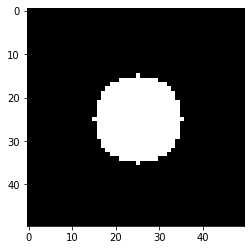

In [ ]:
def create_circular_mask(N, radius=None, center=None):
  # https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
    h,w = N,N
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

doplt(create_circular_mask(50,10))

In [ ]:
x, y = np.mgrid[-1:1:.025, -1:1:.025]
pos = np.dstack((x, y))
pos.shape # grid of 200x200 xy coordinates between -1 and 1

(80, 80, 2)

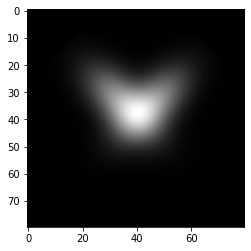

In [ ]:
mu=1
rv = multivariate_normal(mean=[0,0], cov=np.array([[2.0, 0], [0, 0.5]]))
g1 = rv.pdf(5*pos+ np.array([mu,0]))
g2 = rv.pdf(5*pos+ np.array([-mu,-0]))
g1_rot = rotate(g1 ,angle=45,reshape=False)
g2_rot = rotate(g1,angle=-45,reshape=False)
I_2d = g1_rot+g2_rot
N=I_2d.shape[0]
mask = create_circular_mask(N,radius=N/2.1)
I_2d[~mask] = 0
doplt(I_2d)

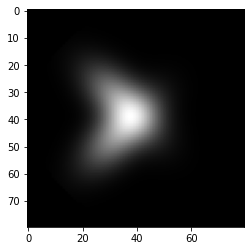

In [ ]:
I1 = rotate(I_2d,angle=+90,reshape=False)
doplt(I1)


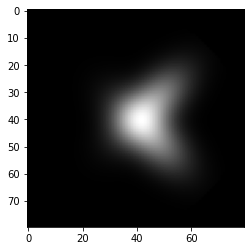

In [ ]:
I2 = rotate(I_2d,angle=-90,reshape=False)
doplt(I2)

# Wasserstein vs L2 distance at different rotations

## Cost

In [ ]:
@numba.jit
def make_C_from_pos(pos_flat):
  N2 = pos_flat.shape[0]
  C = np.empty((N2,N2))
  np.fill_diagonal(C,0)
  for i in range(C.shape[0]):
    for j in range(i,C.shape[1]):
      C[i,j] = np.sqrt(((pos_flat[i] - pos_flat[j])**2).sum())
      C[j,i] = C[i,j]

  return(C)

In [ ]:
%%time
C = make_C_from_pos(pos[mask])
C /= C.max()


CPU times: user 1.54 s, sys: 4.72 ms, total: 1.55 s
Wall time: 1.55 s


In [ ]:
C.shape

(4569, 4569)

In [ ]:
num_angles = 20
angles = np.linspace(0,180,num_angles)
W = np.zeros(num_angles)

for angle_idx, angle in enumerate(angles):
  I1 = rotate(I_2d,angle=angle/2,reshape=False)
  I2 = rotate(I_2d,angle=-angle/2,reshape=False)
  I1_flat = I1[mask]
  I1_flat /= I1_flat.sum()
  I2_flat = I2[mask]
  I2_flat /= I2_flat.sum()
  W[angle_idx] = ot.sinkhorn2(I1_flat,I2_flat,C,reg=0.5)

NameError: ignored

Text(0, 0.5, 'W distance')

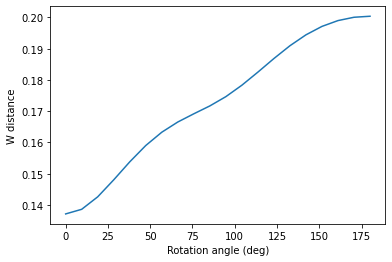

In [ ]:
sr = pd.Series(W)
sr.index = angles
ax = sr.plot()
ax.set_xlabel('Rotation angle (deg)')
ax.set_ylabel('W distance')

We see that the W distance is increasing (monotonically) as the angle does. This makes sense. 

Let's see how things change where there is some noise.

0.003
0.01
0.03
0.1
0.3


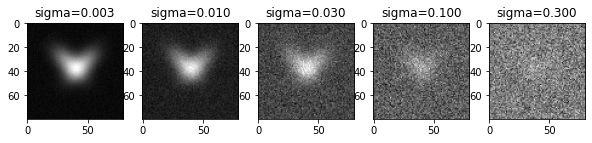

In [ ]:
num_angles = 20
angles = np.linspace(0,180,num_angles)
sigmas = [0.003,.01, 0.03,0.1,0.3]
W = np.zeros((len(sigmas),num_angles))
L2 = np.zeros_like(W)
fig, axes = plt.subplots(ncols=len(sigmas),figsize=(10,10))

for sigma_idx, sigma in enumerate(sigmas):
  print(sigma)
  noise = np.random.normal(loc=0*I_2d,scale=sigma)
  axes[sigma_idx].imshow(I_2d+noise,cmap='gray')
  axes[sigma_idx].set_title('sigma=%.3f'%sigma)
  for angle_idx, angle in enumerate(angles):
    I1 = rotate(I_2d,angle=angle/2,reshape=False) 
    I2 = rotate(I_2d,angle=-angle/2,reshape=False) + noise
    I1_flat = I1[mask]
    I1_flat /= I1_flat.sum()
    I2_flat = I2[mask]
    I2_flat /= I2_flat.sum()
    #W[sigma_idx,angle_idx] = ot.sinkhorn2(I1_flat,I2_flat,C,reg=0.1)
    L2[sigma_idx,angle_idx] = np.sqrt(((I1_flat - I2_flat)**2).sum())


In [ ]:
def rownorm_01(arr2d):
  arr2d -= arr2d.min(1).reshape(-1,1)
  arr2d /= arr2d.max(1).reshape(-1,1)
  return(arr2d)



Text(0, 0.5, 'L2 distance')

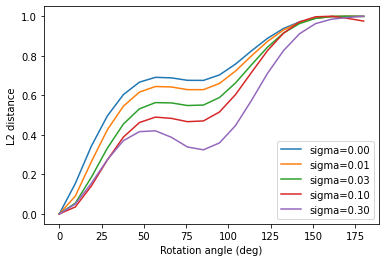

In [ ]:
L2_01 = rownorm_01(L2.copy())
for sigma_idx, sigma in enumerate(sigmas):
  sr = pd.Series(L2_01[sigma_idx,:])
  sr.index = angles
  ax = sr.plot(label='sigma=%.2f'%sigma,legend=True)
ax.set_xlabel('Rotation angle (deg)')
ax.set_ylabel('L2 distance')

Text(0, 0.5, 'W distance')

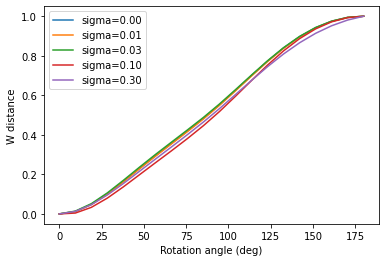

In [ ]:
W_01 = rownorm_01(W.copy())

for sigma_idx, sigma in enumerate(sigmas):
  sr = pd.Series(W_01[sigma_idx,:])
  sr.index = angles
  ax = sr.plot(label='sigma=%.2f'%sigma,legend=True)
ax.set_xlabel('Rotation angle (deg)')
ax.set_ylabel('W distance')

In the EM update, the L2 distances are weighed by a Baysean factor (when combining the contribution of each image in each pixel). The Baysian weight for an image $X_i$, with resspect to template $A$ is $\gamma(\theta) = \sim \exp -\sum_\alpha \frac{X_{i\alpha}-A_{\alpha}(\theta)}{2 \sigma^2}$, where $\theta$ is the latent variable(s) that are averaged over in the Baysean setting (e.g. rotations and shifts). Things work out, if there is more noise, then sigma is higher and weightings are smoothed out. The value of $\sigma$ changes $\gamma$ in a non-linear way, and this can't be seen in the above plots.

It's not clear what exactly to do with the Wp, in order to turn them into Baysean weights.

Now that we see that the W distance is more sensitive to noise, compared with the L2 distance.

Perhaps the regularization parameter can help this.

Let's look at a protein example now, which has all sorts of fine detail, compared with our gaussian blob toy example.

In [ ]:
num_angles = 20
angles = np.linspace(0,180,num_angles)
regs = [0.05,0.1,0.5,1]
sigma = 0.3
W = np.zeros((len(regs),num_angles))
L2 = np.zeros_like(W)
noise = np.random.normal(loc=0*I_2d,scale=sigma)

for reg_idx, reg in enumerate(regs):
  print(reg)
  for angle_idx, angle in enumerate(angles):
    I1 = rotate(I_2d,angle=angle/2,reshape=False) 
    I2 = rotate(I_2d,angle=-angle/2,reshape=False) + noise
    I1_flat = I1[mask]
    I1_flat /= I1_flat.sum()
    I2_flat = I2[mask]
    I2_flat /= I2_flat.sum()
    W[reg_idx,angle_idx] = ot.sinkhorn2(I1_flat,I2_flat,C,reg=reg,numItermax=10**5)
    L2[reg_idx,angle_idx] = np.sqrt(((I1_flat - I2_flat)**2).sum())


0.05
0.1
0.5
1


Text(0, 0.5, 'W distance')

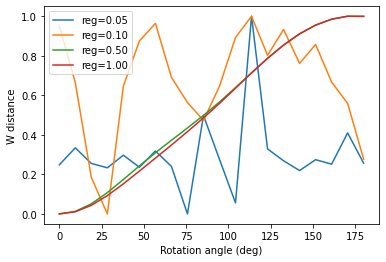

In [106]:
W_01 = rownorm_01(W.copy())

for reg_idx, reg in enumerate(regs):
  sr = pd.Series(W_01[reg_idx,:])
  sr.index = angles
  ax = sr.plot(label='reg=%.2f'%reg,legend=True)
ax.set_xlabel('Rotation angle (deg)')
ax.set_ylabel('W distance')

In [104]:
for numItermax in [10**3,10**4,10**5]:
  print(numItermax,ot.sinkhorn2(I1_flat,I2_flat,C,reg=0.1,numItermax=numItermax))


1000 [0.16920093]
10000 [-0.13617646]
100000 [-0.13617646]


In [105]:
for numItermax in [10**3,10**4,10**5]:
  print(numItermax,ot.sinkhorn2(I1_flat,I2_flat,C,reg=0.5,numItermax=numItermax))

1000 [0.2383865]
10000 [0.2383865]
100000 [0.2383865]


We can see the issues with numerical convergence in the above two examples. We get differente values when reg is too small.

How do we pick a good regularization? And what exactly does it control? If different regs give the same Wp curve, then they will not affect how the template is updated, just computational efficiency. When it is too high or too low, is there pathalogical behaviour? Perhaps 
- numerical issues when it is too low (or it takes too long when using more expensive methods, or more iterations)?
- doesn't recapitulate the right ground truth angle when too high/low.
  - NB: `method='sinkhorn_epsilon_scaling'` is much slower, but can't get working with ot.sinkhorn2 (shape bug)
- need more iterations for lower `reg` (e.g. `numIterMax=10**5` for `reg=0`.05, and `10**4` for `reg=0.1`)